## In this R notebook I use Millar et al's workflow for automatic event delineation using the s::can and discharge data from [Kincaid et al., 2020](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020WR027361). In [this notebook](https://github.com/MeganEDuffy/cQ_analysis/blob/main/md-notebooks/Kincaid2020_Millar_workflow.ipynb) I follow through with event hysteresis index and flushing index determination, but here I am just adjusting the Millar code to get event water yields and nutrient yields for this dataset.

- ### Data publicly available here on HydroShare: https://www.hydroshare.org/resource/85fa32a11fbb49779033934a135f54ef/

- ### This larger dataset includes the 2014-2015 discharge and nitrate data from Vaughan, M. (2017). Vermont NEWRnet stations: 2014-2015 high-frequency DOC, nitrate, and discharge data, HydroShare, http://www.hydroshare.org/resource/faac1672244c407e9c9c8644c8211fd6.

- ### Note that there is a Hungerford data gap in 2016 to adjust this code for

- ### I downloaded on 05.02.24 and put it here in this directory /home/millieginty/OneDrive/git-repos/cQ_analysis/millar2021_R_partition_hysteresis

- ### The raw data file has discharge (q m3s), NO3, and SRP with timestamp and event start/end times for each watershed. The Millar code takes just timestamp, q, and C input csvs so I separate this raw data file into just those parameters for each site over the entire time period (>400 events from 2014 to 2018, no winter events).

## I also plot the original Kincaid 2020 events as delineated using HydRun with manual interventions.
 
 - ### Data were copied to this repo from the BREE OneDrive directory. One csv for each watershed, 2014-2018.
 
 - ### For modifying the Millar code to allow for custon event inputs - see this notebook: https://github.com/MeganEDuffy/cQ_analysis/blob/main/md-notebooks/Kincaid2020_Millar_custom-input.ipynb

## Kincaid 2020 RDF (HydRun) parameters, prior to manual manipulation

- Taken from the SI (Table S3)


|            | catchment area (km2) | Kincaid 2020 HydRun SFT (cms) | Kincaid 2020 HydRun baseflow separation FC | Kincaid 2020 return ratio (0-1) | Kincaid 2020 minimum event duration (hr) |
|------------|----------------------|-------------------------------|--------------------------------------------|---------------------------------|------------------------------------------|
| Hungerford | 48.1                 |  			0.10 		                        |  			0.996 		                                    |  			0.18 		                          | 6                                        |
| Wade       | 16.7                 |  			0.05 		                        |  			0.996 		                                    |  			0.18 		                          | 4                                        |
| Potash     | 18.4                 |  			0.12 		                        |  			0.996 		                                    |  			0.20 		                          | 4                                        |

### TO DO

- [x] change 'Hford' df name to something non site-specific
- [x] loop through all water years and combine into single storm event df
- [x] add in NO3 yields
- [x] fix file naming (get rid of spaces)
- [x] adaptive Area inputs (1st cell)
- [x] adaptive for `candidateSfThresh` inputs
- [x] fix the loss of start time (not an issue in Millar orginal
    - The problem is not related to the functions script, it's related to the code here and calling type 'Date'
    - `eventsData1$start <- as.Date(eventsData1$start)` # got rid of this line
- [x] find and [ ] plot Kincaid event ranges and yields
- [x] interactive viewer with plotly
    - [ ] fix colors
    - [ ] fix superscripts
    - [ ] add fit line eq

In [1]:
#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)

###################
# SET DIRECTORIES #
###################

# Define the input and output directories

# For Kincaid data, input and output in separate directory
input_dir <- "/home/millieginty/OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/kincaid2020_hydroshare/"
output_dir <- "/home/millieginty/OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/kincaid2020_hydroshare/output/"

# functions script in main millar directory
millar_input_dir <- "/home/millieginty/OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/"

#####################
# READ IN FUNCTIONS #
#####################

# 2024-07-08 MED note: I made a new version of the Millar functions script with my modifications
source(file.path(input_dir,"cQ_functions_MED.R")) # MED modifications that produce water and nitrate yields
#source(file.path(input_dir,"cQ_functions.R")) # original functions

#################
# SET SITE INFO #
#################

# Set site name
Site = "Wade"

# Set year if doing yearly
#Year = 2015

# Set constituent
Analyte = "NO3"

# Set catchment area based on Site
if (Site == "Hungerford") {
  Area <- 48.1
} else if (Site == "Potash") {
  Area <- 18.4
} else if (Site == "Wade") {
  Area <- 16.7
} else {
  Area <- NA  # or any default value if Site is not one of the specified values
}

# Set stormflow thresholds 
# In this case, based on Kincaid values above in table. Can use a range in other cases (see cell below).
if (Site == "Hungerford") {
  candidateSfThresh <- 0.1
} else if (Site == "Potash") {
  candidateSfThresh <- 0.12
} else if (Site == "Wade") {
  candidateSfThresh <- 0.05
} else {
  candidateSfThresh <- NA  # or any default value if Site is not one of the specified values
}

# Print the Area and SFT to check
print(Area)
print(candidateSfThresh)

#########################
# READ IN AND TIDY DATA #
#########################

# Read in raw Hydroshare data csv from Kincaid et al 2020 found at https://www.hydroshare.org/resource/85fa32a11fbb49779033934a135f54ef/
# Downloaded on 05.02.24
allInputData15Min <- read.csv(file.path(input_dir,"hydroshare_rawData.csv"))

# Rename the 'timestamp' column to 'datetime' to conform with Millar script
names(allInputData15Min)[names(allInputData15Min) == "timestamp"] <- "datetime"

# Filter the data for just the site and for the year/time range you want
# Memory issues if you try to process all the Kincaid 2014-2018 data at once, sometimes
# Remove rows with missing values
Site_input <- allInputData15Min %>%
  #filter(site == Site & year(datetime) == Year) %>%
  filter(site == Site) %>%
  drop_na(q_cms, NO3_mgNL) %>%
  select(datetime, q_cms, conc = NO3_mgNL)

# Specify constituent in data set name
dataSetName = paste(Site,"_",Analyte,"_","2014-2018", sep="")

# Chose constitution for plot axes labels (NO3, TOC, or turbidity)
constit <- Analyte

Site_input$datetime <- as.POSIXct(Site_input$datetime,format("%Y-%m-%d %H:%M:%S"),tz="EST")

# Rescale the data
Site_input <- Site_input %>% 
  mutate(rescaled_conc = ((conc-min(conc))/(max(conc)-min(conc))*max(q_cms)))

── Attaching core tidyverse packages ────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: viridisLite



[1] 16.7
[1] 0.05


### Running Millar batch event delineation with Kincaid parameters

- 2024-07-08 MED note: I went into cQ_functions_MED.R and changed the `stormEventCalcs` function so that a column called `tot_constit_mgNL` is created, a nitrate/DOC/any constituent analog of the `tot_q_m3` that is calculated in the original Millar script.

In [2]:
###################
# SET RDF PARAMS #
##################

# Vector containing candidate baseflow separation filter values
candidateFilterPara <- c(0.996,0.98) # Kincaid 2020 used 0.996 for all catchments

# Vector containing candidate stormflow threshold values
#candidateSfThresh <- c(0.098,0.1,0.12) #See cell above for Kincaid comparison use case

# Vector with interpolation intervals used for calculating HI
interp <- seq(0,1,0.01)

###############################
# RUN ANALYSIS TO GET EVENTS #
###############################

batchRun1 <- batchRunBfAndEvSepForCQ(qInputs = Site_input,
                                     bfSepPasses = 3, # orig 3
                                     filterParam = candidateFilterPara,
                                     sfSmoothPasses = 4, # orig 4
                                     sfThresh = candidateSfThresh,
                                     cInputs = Site_input,
                                     timeStep = 15,
                                     minDuration = 4, # Kincaid 2020 uses 4 hrs for Hungerford
                                     maxDuration = 200)

eventsDataAll1 <- getAllStormEvents(batchRun = batchRun1,
                                    timestep_min = 15)

batchRunFlowsLF1 <- batchRunflowCompare(qData = Site_input,
                                         bfSepPasses = 4, # orig 4
                                         filterPara = candidateFilterPara,
                                         sfSmoothPasses = 4) # orig 4

eventsData1 <- stormEventCalcs(batchRun = batchRun1,
                               timestep_min = 15)

eventsData1$filter_para <- as.numeric(eventsData1$filter_para)

# Add water yield column (in mm) using catchment area
eventsData1 <- eventsData1 %>%
  mutate(
    water_yield_mm = tot_q_m3 / (Area * 10^6) * 1000,
  )

# Add constituent yield column (in mm) using catchment area
eventsData1 <- eventsData1 %>%
  mutate(
    constit_yield_mm = (tot_constit_mgN) / (Area * 10^6),
  )

stormCounts1 <- stormCounts(batchRun1)

# Not dealing with HI calc in this workflow
#hysteresisData1 <- getHysteresisIndices(batchRun = batchRun1,
                                        #xForInterp = interp,
                                        #eventsData = eventsData1)


### Export the results

### change from Millar: calculate water yield and save in the file called "_StormEventSummaryData.csv"

In [4]:
##################
# EXPORT OUTPUT  #
##################

write.csv(eventsData1,file = file.path(output_dir,paste(dataSetName,"_StormEventSummaryData.csv",sep="")))
write.csv(batchRunFlowsLF1,file = file.path(output_dir,paste(dataSetName,"_DischargeData.csv",sep="")))
#write.csv(hysteresisData1,file = file.path(output_dir,paste(dataSetName,"_HysteresisData.csv",sep="")))
write.csv(eventsDataAll1,file = file.path(output_dir,paste(dataSetName,"_AllCQData.csv",sep="")))
write.csv(stormCounts1,file = file.path(output_dir,paste(dataSetName,"_StormCounts.csv",sep="")))

### Plot and save event delineation data

In [5]:
#########################################
# PLOT AND SAVE DATA - EVENT SEPARATION #
#########################################

# Make subfolder in output directory to save hydrograph plots
dir.create(file.path(output_dir, "Hydrographs"), showWarnings = FALSE)

# 1) Plot and save the hydrograph with input data
# MED note that for the Kincaid data I had to change 'timestamp' to 'datetime'when reading in the csv

initialHydrograph <- ggplot(Site_input,aes(x=datetime, y=q_cms)) +
                            geom_line(size=0.5, color="black") +
                            xlab(NULL) +
                            ylab(expression(paste("Total discharge (",m^3," ",s^-1,")"))) +
                            theme_bw() +
                            theme(text=element_text(size=18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_TotalDischarge.jpeg")),
       initialHydrograph,
       width = 12, 
       height = 4, 
       units = "in",
       dpi=600)


# 2) Plot total discharge with baseflow

baseflowHydrograph <- ggplot() + 
                            geom_line(data=batchRunFlowsLF1, aes(x=datetime, y=total_flow), size=0.5, color="black") +
                            geom_line(data=batchRunFlowsLF1, aes(x=datetime, y=base_flow,color=filter_para), size=0.75) +
                            scale_color_brewer(palette = "Set1") +
                            xlab(NULL) +
                            ylab(expression(paste("Discharge (",m^3," ",s^-1,")"))) +
                            theme_bw() +
                            theme(legend.title = element_blank(),
                                  text=element_text(size=18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_Baseflows.jpeg")),
       baseflowHydrograph,
       width = 14, 
       height = 4, 
       units = "in",
       dpi=600)


# 3) Plot smoothed storm flows

stormflowHydrograph <- ggplot() + 
  geom_line(data=batchRunFlowsLF1, aes(x=datetime, y=storm_flow,color=filter_para), size=0.75) +
  scale_color_brewer(palette = "Set1") +
  xlab(NULL) +
  ylab(expression(paste("Storm flow (",m^3," ",s^-1,")"))) +
  theme_bw() +
  theme(legend.title = element_blank(),
        text=element_text(size=18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_StormflowsOnly.jpeg")),
       stormflowHydrograph,
       width = 14, 
       height = 4, 
       units = "in",
       dpi=600)


# 3a) Plot smoothed storm flows with storm flow thresholds

stormflowThreshHydrograph <- ggplot() + 
  geom_line(data=batchRunFlowsLF1, aes(x=datetime, y=storm_flow,color=filter_para), size=0.75) +
  scale_color_brewer(palette = "Set1") +
  geom_hline(yintercept = candidateSfThresh, linetype = "dashed", color = "black",alpha=0.5) +
  xlab(NULL) +
  ylab(expression(paste("Storm flow (",m^3," ",s^-1,")"))) +
  theme_bw() +
  theme(legend.title = element_blank(),
        text=element_text(size=18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_StormflowsOnlyWithThresholds.jpeg")),
       stormflowThreshHydrograph,
       width = 14, 
       height = 4, 
       units = "in",
       dpi=600)


# 4) Plot batch run event separation hydrographs
eventsDataShaded1 <- eventsData1 %>% mutate(start = as.POSIXct(start,
                                                                   format("%Y-%m-%d %H:%M:%S"),tz="EST"),
                                            end = as.POSIXct(end,
                                                                   format("%Y-%m-%d %H:%M:%S"),tz="EST"),
                                            tops = max(Site_input$q_cms),
                                            bottoms = 0)

batchEventSepPlot <- ggplot() + 
  geom_rect(data=eventsDataShaded1, mapping=aes(xmin=start, 
                                                xmax=end, 
                                                ymin=bottoms, 
                                                ymax=tops), fill="green", color="red", alpha=0.2) +
  
  geom_line(data=Site_input, aes(x=datetime, y=q_cms), size=0.8, color="blue") +
  geom_line(data=Site_input, aes(x=datetime, y=rescaled_conc), size=0.5, color="black",linetype="dashed") +
  facet_wrap(~ run_id, ncol = 1) +
  scale_color_brewer(palette = "Set1") +
  xlab(NULL) +
  ylab(expression(paste("Discharge (",m^3," ",s^-1,")"))) +
  theme_bw() +
  theme(legend.title = element_blank(),
        text=element_text(size=18))


ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_BatchEventSeparationPlot.jpeg")),
       batchEventSepPlot,
       width = 8, 
       height = 10, 
       units = "in",
       dpi=600)

# Just viewing the yearly hydrograph here
#initialHydrograph

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 9 rows containing missing values (`geom_rect()`).”


## Visualizing the water yield output:


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


`geom_smooth()` using formula = 'y ~ x'


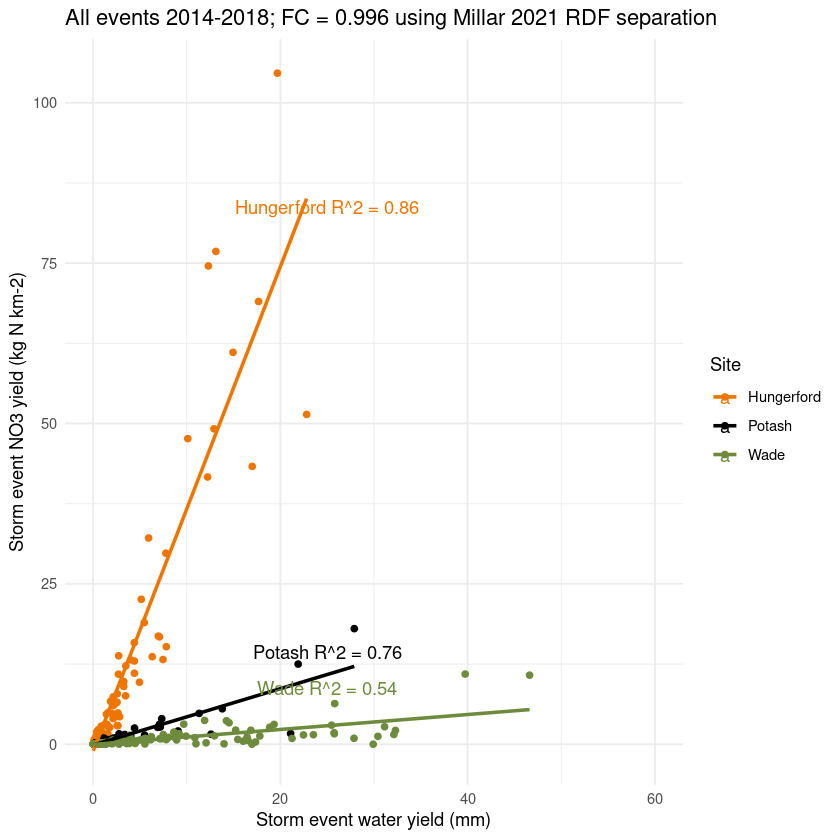

In [6]:
###############################
# LOAD PLOTTING PACKAGES #
###############################

library(ggplot2)
library(plotly)
library(gapminder)

# Import the yield data from output csvs and put in a list

summary_files <- list.files(file.path(output_dir), pattern = "\\StormEventSummaryData.csv$", full.names = TRUE)
summary_data = lapply(summary_files, read.csv)

# Define colors for each site
colors <- c("Potash" = "black", "Hungerford" = "darkorange2", "Wade" = "darkolivegreen4")

# Filter each dataframe and store in a new list
# Want FC = 0.996 and SFT = 0.1 cms for Hford; 0.05 cms for Wade; 0.12 cms for Potash
filtered_data_list <- lapply(summary_data, function(df) {
  subset(df, filter_para == 0.996)
})

# Assign site names to the list elements
names(filtered_data_list) <- c("Hungerford", "Potash", "Wade")

# Combine dataframes into one, adding a site identifier
combined_data <- do.call(rbind, lapply(names(filtered_data_list), function(site) {
  df <- filtered_data_list[[site]]
  df$Site <- site
  return(df)
}))

# Convert Site to a factor to ensure proper color mapping
combined_data$Site <- factor(combined_data$Site, levels = c("Hungerford", "Potash", "Wade"))

# Initialize the plot
storm_yields_plot <- ggplot(combined_data, aes(y = constit_yield_mm, x = water_yield_mm, color = Site)) + 
  geom_point() + 
  geom_smooth(method = "lm", se = FALSE) +
  scale_color_manual(values = colors) +
  labs(title = "All events 2014-2018; FC = 0.996 using Millar 2021 RDF separation", 
       x = "Storm event water yield (mm)",
       y = "Storm event NO3 yield (kg N km-2)") +
  xlim(0, 60) +
  theme_minimal()

# Calculate and annotate R^2 values for each site
r_squared_annotations <- lapply(names(filtered_data_list), function(site) {
  data <- filtered_data_list[[site]]
  fit <- lm(constit_yield_mm ~ water_yield_mm, data = data)
  r_squared <- summary(fit)$r.squared
  annotation_text <- paste(site, "R^2 =", round(r_squared, 2))
  data.frame(Site = site, x = 25, y = max(data$constit_yield_mm) * 0.8, label = annotation_text, stringsAsFactors = FALSE)
})

annotations <- do.call(rbind, r_squared_annotations)

# Add annotations to the plot
storm_yields_plot <- storm_yields_plot + 
  geom_text(data = annotations, aes(x = x, y = y, label = label, color = Site))

# Display the plot
print(storm_yields_plot)

## Make interactive plot using plotly so you can hover and see start and end times

- ### Plotly won't display in notebook, but this saves out an HTML that you can view in a browser window

In [ ]:
###############################
# LOAD PLOTTING PACKAGES #
###############################

library(ggplot2)
library(plotly)
library(gapminder)
library(htmlwidgets)

# Import the yield data from output CSVs and put it in a list
summary_files <- list.files(file.path(output_dir), pattern = "\\StormEventSummaryData.csv$", full.names = TRUE)
summary_data <- lapply(summary_files, read.csv)

# Define colors for each site
colors <- c("Potash" = "black", "Hungerford" = "darkorange1", "Wade" = "palegreen3")

# Filter each dataframe and store in a new list
filtered_data_list <- lapply(summary_data, function(df) {
  subset(df, filter_para == 0.996)
})

# Assign site names to the list elements
names(filtered_data_list) <- c("Hungerford", "Potash", "Wade")

# Combine dataframes into one, adding a site identifier
combined_data <- do.call(rbind, lapply(names(filtered_data_list), function(site) {
  df <- filtered_data_list[[site]]
  df$Site <- site
  # Ensure 'start' and 'end' are character columns
  df$start <- as.character(df$start)
  df$end <- as.character(df$end)
  return(df)
}))

# Convert site to a factor to ensure proper color mapping
combined_data$Site <- factor(combined_data$Site, levels = c("Hungerford", "Potash", "Wade"))

# Create the plot using plotly
storm_yields_plotly <- plot_ly(
  combined_data, 
  x = ~water_yield_mm, 
  y = ~constit_yield_mm, 
  type = 'scatter', 
  mode = 'markers', 
  color = ~Site,
  size = ~duration_hrs,
  colors = colors,
  text = ~paste("Start:", start, "<br>End:", end, "<br>Duration:", duration_hrs, "hrs"),
  hoverinfo = 'text'
) %>%
  layout(
    title = "All events 2014-2018; FC = 0.996 using Millar 2021 RDF separation",
    xaxis = list(title = "Storm event water yield (mm)", range = c(0, 60)),
    yaxis = list(title = "Storm event NO3 yield (kg N km-2)"),
    legend = list(title = list(text = "Site"))
  )

# Calculate and annotate R^2 values for each site and add regression lines
r_squared_annotations <- lapply(names(filtered_data_list), function(site) {
  data <- filtered_data_list[[site]]
  fit <- lm(constit_yield_mm ~ water_yield_mm, data = data)
  r_squared <- summary(fit)$r.squared
  annotation_text <- paste(site, "R^2 =", round(r_squared, 2))
  annotation <- list(
    x = 25, 
    y = max(data$constit_yield_mm) * 0.8, 
    text = annotation_text, 
    showarrow = FALSE, 
    font = list(color = colors[[site]])
  )
  storm_yields_plotly <<- storm_yields_plotly %>%
    add_lines(
      x = data$water_yield_mm, 
      y = predict(fit), 
      line = list(color = colors[[site]]), 
      name = paste(site, "fit"),
      inherit = FALSE
    )
  return(annotation)
})

annotations <- do.call(list, r_squared_annotations)

# Add annotations to the plot
storm_yields_plotly <- storm_yields_plotly %>% layout(annotations = annotations)

# Save the interactive plot as an HTML file
saveWidget(storm_yields_plotly, file = file.path(output_dir, "storm_yields_plot.html"))

# Display the interactive plot
storm_yields_plotly